In [1]:
!pip install vllm matplotlib autoawq accelerate

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
#模型下载
from modelscope import snapshot_download
cache_dir = '/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/'
model_dir = snapshot_download('Qwen/Qwen2-7B-Instruct', cache_dir=cache_dir, revision='master')

2025-03-14 03:40:29,191 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


In [3]:
from vllm import LLM, SamplingParams
import matplotlib.pyplot as plt
import time

In [4]:
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]
sampling_params = SamplingParams(temperature=0.8, top_p=0.95)

In [5]:
model_path = "/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct"

llm = LLM(model=model_path, gpu_memory_utilization=0.4)

INFO 03-14 03:40:30 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 03:40:36 config.py:549] This model supports multiple tasks: {'reward', 'embed', 'classify', 'generate', 'score'}. Defaulting to 'generate'.
INFO 03-14 03:40:36 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observabi

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 03-14 03:41:49 model_runner.py:1115] Loading model weights took 14.2487 GB
INFO 03-14 03:41:52 worker.py:267] Memory profiling takes 2.62 seconds
INFO 03-14 03:41:52 worker.py:267] the current vLLM instance can use total_gpu_memory (79.33GiB) x gpu_memory_utilization (0.40) = 31.73GiB
INFO 03-14 03:41:52 worker.py:267] model weights take 14.25GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 4.35GiB; the rest of the memory reserved for KV Cache is 13.04GiB.
INFO 03-14 03:41:52 executor_base.py:111] # cuda blocks: 15257, # CPU blocks: 4681
INFO 03-14 03:41:52 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 7.45x
INFO 03-14 03:41:54 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:13<00:00,  2.64it/s]

INFO 03-14 03:42:08 model_runner.py:1562] Graph capturing finished in 13 secs, took 0.78 GiB
INFO 03-14 03:42:08 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 18.84 seconds


In [6]:
outputs = llm.generate(prompts, sampling_params)

for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")

Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 15.89it/s, est. speed input: 87.40 toks/s, output: 254.24 toks/s]

Prompt: 'Hello, my name is', Generated text: " Jamie and I'm a new member to the team! I'll be here to"
Prompt: 'The president of the United States is', Generated text: ' a powerful person. They can sign or veto laws, negotiate international treaties, and'
Prompt: 'The capital of France is', Generated text: ' Paris. It is the second largest city in France after Marseille. Paris is the'
Prompt: 'The future of AI is', Generated text: ' in the cloud, and we’re in it.\nThe Cloud Intelligence team at NVIDIA'


## FP16

In [7]:
# constants
max_tokens = 10
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=max_tokens)
# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(10)]
for batch_size in batch_sizes:
    print(f"bs={batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompt = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]

    outputs = llm.generate(batch_prompt, sampling_params)

    duration_s = time.time() - t0

    # calculate throughput
    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"duration: {duration_s}")
    print(f"throughput: {throughput} tokens/s")
    print(f"avg latency: {avg_latency}")
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)


bs=1


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s, est. speed input: 37.59 toks/s, output: 75.18 toks/s]


duration: 0.13795018196105957
throughput: 72.48993700365534 tokens/s
avg latency: 0.013795018196105957

bs=2


Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 14.93it/s, est. speed input: 89.65 toks/s, output: 149.37 toks/s]


duration: 0.1380014419555664
throughput: 144.92602190663763 tokens/s
avg latency: 0.01380014419555664

bs=4


Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 29.89it/s, est. speed input: 164.48 toks/s, output: 299.02 toks/s]


duration: 0.13796758651733398
throughput: 289.92316970750574 tokens/s
avg latency: 0.013796758651733399

bs=8


Processed prompts: 100%|██████████| 8/8 [00:00<00:00, 55.86it/s, est. speed input: 307.38 toks/s, output: 558.85 toks/s]


duration: 0.14818263053894043
throughput: 539.8743409334811 tokens/s
avg latency: 0.014818263053894044

bs=16


Processed prompts: 100%|██████████| 16/16 [00:00<00:00, 104.69it/s, est. speed input: 576.04 toks/s, output: 1047.28 toks/s]


duration: 0.15908026695251465
throughput: 1005.7815659044619 tokens/s
avg latency: 0.015908026695251466

bs=32


Processed prompts: 100%|██████████| 32/32 [00:00<00:00, 185.01it/s, est. speed input: 1017.91 toks/s, output: 1850.64 toks/s]


duration: 0.18071198463439941
throughput: 1770.773535841554 tokens/s
avg latency: 0.018071198463439943

bs=64


Processed prompts: 100%|██████████| 64/64 [00:00<00:00, 285.86it/s, est. speed input: 1572.70 toks/s, output: 2859.33 toks/s]


duration: 0.23776626586914062
throughput: 2691.719103467086 tokens/s
avg latency: 0.02377662658691406

bs=128


Processed prompts: 100%|██████████| 128/128 [00:00<00:00, 403.55it/s, est. speed input: 2220.15 toks/s, output: 4030.26 toks/s]


duration: 0.3396167755126953
throughput: 3768.9539866447262 tokens/s
avg latency: 0.03396167755126953

bs=256


Processed prompts: 100%|██████████| 256/256 [00:00<00:00, 456.81it/s, est. speed input: 2512.89 toks/s, output: 4568.82 toks/s]


duration: 0.5962953567504883
throughput: 4293.174466342855 tokens/s
avg latency: 0.05962953567504883

bs=512


Processed prompts: 100%|██████████| 512/512 [00:01<00:00, 457.93it/s, est. speed input: 2518.84 toks/s, output: 4579.68 toks/s]

duration: 1.2019188404083252
throughput: 4259.8550150529245 tokens/s
avg latency: 0.12019188404083252



In [8]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()

    # plot the first line
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # set the x-axis to be log scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

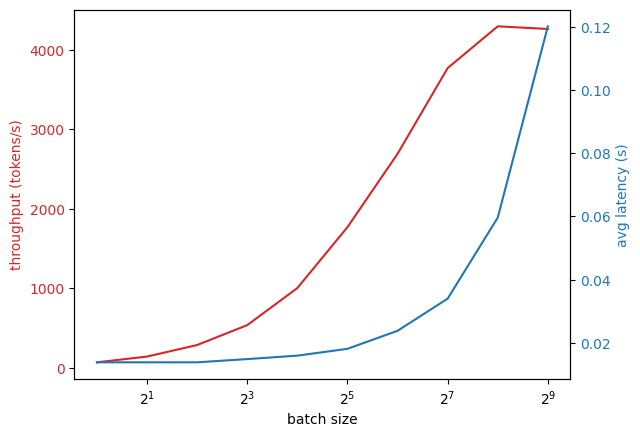

In [9]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "batch size",
    "throughput (tokens/s)",
    "avg latency (s)"
)

## AWQ

In [10]:
# import subprocess
# import os

# result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
# output = result.stdout
# for line in output.splitlines():
#     if '=' in line:
#         var, value = line.split('=', 1)
#         os.environ[var] = value

In [11]:
from vllm import LLM, SamplingParams
import matplotlib.pyplot as plt
import time

In [12]:
# from awq import AutoAWQForCausalLM
# from transformers import AutoTokenizer
# model_path = "/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct"

# quant_path = "/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct-self-awq"
# quant_config = { "zero_point": True, "q_group_size": 128, "w_bit": 4, "version": "GEMM" }

# # Load model
# model = AutoAWQForCausalLM.from_pretrained(
#     model_path, **{"low_cpu_mem_usage": True, "use_cache": False}
# )
# tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

# # Quantize
# model.quantize(tokenizer, quant_config=quant_config)

# # Save quantized model
# model.save_quantized(quant_path)
# tokenizer.save_pretrained(quant_path)

# print(f'Model is quantized and saved at "{quant_path}"')

In [13]:
# from vllm import LLM, SamplingParams

# Sample prompts.
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]
# Create a sampling params object.
sampling_params = SamplingParams(temperature=0.8, top_p=0.95)

In [14]:
model = "/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct-AWQ"
# Create an LLM.
llm_awq = LLM(model=model, quantization="AWQ", gpu_memory_utilization=0.4)

INFO 03-14 03:42:12 config.py:549] This model supports multiple tasks: {'reward', 'embed', 'classify', 'generate', 'score'}. Defaulting to 'generate'.
INFO 03-14 03:42:12 awq_marlin.py:118] Detected that the model can run with awq_marlin, however you specified quantization=awq explicitly, so forcing awq. Use quantization=awq_marlin for faster inference
WARNING 03-14 03:42:12 config.py:628] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 03-14 03:42:12 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct-AWQ', speculative_config=None, tokenizer='/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct-AWQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=32768, download_dir=None, l

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 03-14 03:42:41 model_runner.py:1115] Loading model weights took 5.2027 GB
INFO 03-14 03:42:44 worker.py:267] Memory profiling takes 2.27 seconds
INFO 03-14 03:42:44 worker.py:267] the current vLLM instance can use total_gpu_memory (79.33GiB) x gpu_memory_utilization (0.40) = 31.73GiB
INFO 03-14 03:42:44 worker.py:267] model weights take 5.20GiB; non_torch_memory takes 0.01GiB; PyTorch activation peak memory takes 4.47GiB; the rest of the memory reserved for KV Cache is 22.05GiB.
INFO 03-14 03:42:44 executor_base.py:111] # cuda blocks: 25805, # CPU blocks: 4681
INFO 03-14 03:42:44 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 12.60x
INFO 03-14 03:42:46 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_u

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:17<00:00,  2.06it/s]

INFO 03-14 03:43:03 model_runner.py:1562] Graph capturing finished in 17 secs, took 1.28 GiB
INFO 03-14 03:43:03 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 22.15 seconds


In [15]:
# Generate texts from the prompts. The output is a list of RequestOutput objects
# that contain the prompt, generated text, and other information.
outputs = llm_awq.generate(prompts, sampling_params)
# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")

Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 18.79it/s, est. speed input: 103.38 toks/s, output: 300.74 toks/s]

Prompt: 'Hello, my name is', Generated text: " Jamie and I'm a new member to the team!\nI'm excited to share"
Prompt: 'The president of the United States is', Generated text: ' a powerful person. They can sign any bill into law, veto bills passed by'
Prompt: 'The capital of France is', Generated text: ' Paris. It is the most populous city in France and the second most populous city'
Prompt: 'The future of AI is', Generated text: ' in the cloud, and we’re in it.\nThe Cloud Intelligence team within the'


In [16]:
import time
# constants
max_tokens = 10
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=max_tokens)
# observations
durations_awq = []
throughputs_awq = []
latencies_awq = []

batch_sizes = [2**p for p in range(10)]
for batch_size in batch_sizes:
    print(f"bs={batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompt = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]

    outputs = llm_awq.generate(batch_prompt, sampling_params)

    duration_s = time.time() - t0

    # calculate throughput
    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"duration: {duration_s}")
    print(f"throughput: {throughput} tokens/s")
    print(f"avg latency: {avg_latency}")
    print()

    durations_awq.append(duration_s)
    throughputs_awq.append(throughput)
    latencies_awq.append(avg_latency)


bs=1


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s, est. speed input: 41.96 toks/s, output: 83.91 toks/s]


duration: 0.12357807159423828
throughput: 80.92050532099613 tokens/s
avg latency: 0.012357807159423828

bs=2


Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 16.72it/s, est. speed input: 100.48 toks/s, output: 167.34 toks/s]


duration: 0.12412714958190918
throughput: 161.12510492156574 tokens/s
avg latency: 0.012412714958190917

bs=4


Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 32.33it/s, est. speed input: 177.95 toks/s, output: 323.51 toks/s]


duration: 0.12836003303527832
throughput: 311.62347854029025 tokens/s
avg latency: 0.012836003303527832

bs=8


Processed prompts: 100%|██████████| 8/8 [00:00<00:00, 59.93it/s, est. speed input: 329.82 toks/s, output: 599.62 toks/s]


duration: 0.13786768913269043
throughput: 580.2664895833874 tokens/s
avg latency: 0.013786768913269043

bs=16


Processed prompts: 100%|██████████| 16/16 [00:00<00:00, 99.97it/s, est. speed input: 550.12 toks/s, output: 1000.13 toks/s]


duration: 0.16649603843688965
throughput: 960.9838258142582 tokens/s
avg latency: 0.016649603843688965

bs=32


Processed prompts: 100%|██████████| 32/32 [00:00<00:00, 143.73it/s, est. speed input: 791.14 toks/s, output: 1438.36 toks/s]


duration: 0.23230242729187012
throughput: 1377.5146636670509 tokens/s
avg latency: 0.02323024272918701

bs=64


Processed prompts: 100%|██████████| 64/64 [00:00<00:00, 186.23it/s, est. speed input: 1024.87 toks/s, output: 1863.34 toks/s]


duration: 0.35895729064941406
throughput: 1782.94191724629 tokens/s
avg latency: 0.03589572906494141

bs=128


Processed prompts: 100%|██████████| 128/128 [00:00<00:00, 219.62it/s, est. speed input: 1209.17 toks/s, output: 2193.30 toks/s]


duration: 0.6100766658782959
throughput: 2098.0969632025676 tokens/s
avg latency: 0.06100766658782959

bs=256


Processed prompts: 100%|██████████| 256/256 [00:00<00:00, 269.35it/s, est. speed input: 1481.54 toks/s, output: 2693.68 toks/s]


duration: 0.9923906326293945
throughput: 2579.629347384242 tokens/s
avg latency: 0.09923906326293945

bs=512


Processed prompts: 100%|██████████| 512/512 [00:01<00:00, 269.67it/s, est. speed input: 1483.25 toks/s, output: 2696.80 toks/s]

duration: 1.9662246704101562
throughput: 2603.975057912361 tokens/s
avg latency: 0.19662246704101563



In [17]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()

    # plot the first line
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # set the x-axis to be log scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

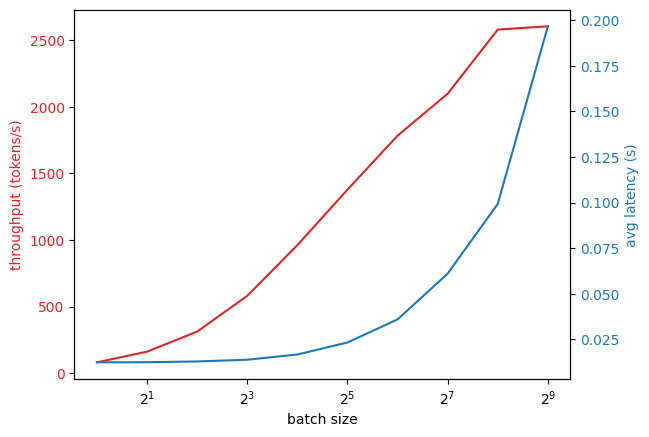

In [18]:
render_plot(
    batch_sizes,
    throughputs_awq,
    latencies_awq,
    "batch size",
    "throughput (tokens/s)",
    "avg latency (s)"
)

## AWQ vs. FP32

In [21]:
def render_plot(x, y1, y2, y3, y4, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()

    # plot the first line (FP32 throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color, label='FP16 Throughput', linestyle='-')
    ax1.tick_params(axis='y', labelcolor=color)

    # plot the third line (AWQ throughput)
    ax1.plot(x, y3, color=color, label='AWQ Throughput', linestyle='--')

    # set the x-axis to be log scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(x, y2, color=color, label='FP16 Latency', linestyle='-')
    ax2.tick_params(axis='y', labelcolor=color)

    # plot the fourth line (AWQ latency)
    ax2.plot(x, y4, color=color, label='AWQ Latency', linestyle='--')

    # Add legends
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

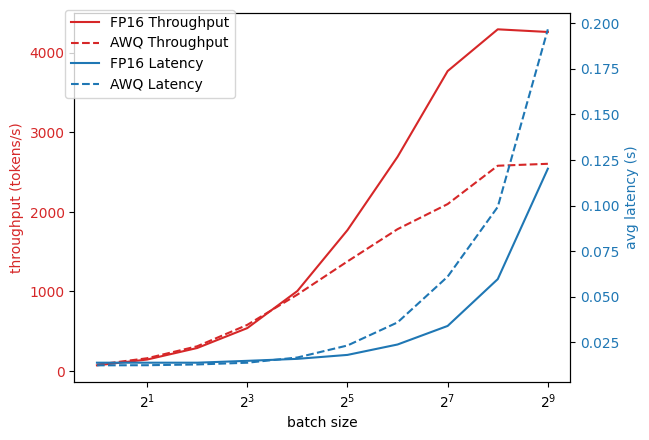

In [22]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    throughputs_awq,
    latencies_awq,
    "batch size",
    "throughput (tokens/s)",
    "avg latency (s)"
)